We ensure the latest versions of numpy, catboost, and optuna are installed by first uninstalling and reinstalling them.

In [ ]:
!pip uninstall catboost numpy
!pip install numpy
!pip install catboost
!pip install optuna

Found existing installation: numpy 2.3.0
Uninstalling numpy-2.3.0:
  Would remove:
    /usr/local/bin/f2py
    /usr/local/bin/numpy-config
    /usr/local/lib/python3.11/dist-packages/numpy-2.3.0.dist-info/*
    /usr/local/lib/python3.11/dist-packages/numpy.libs/libgfortran-040039e1-0352e75f.so.5.0.0
    /usr/local/lib/python3.11/dist-packages/numpy.libs/libquadmath-96973f99-934c22de.so.0.0.0
    /usr/local/lib/python3.11/dist-packages/numpy.libs/libscipy_openblas64_-56d6093b.so
    /usr/local/lib/python3.11/dist-packages/numpy/*
Proceed (Y/n)? Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/uninstall.py", line 106, in run
    uninstall_pathset = req.uninstall(
                        ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_intern

# Libraries 📖
***

We import libraries for data handling, preprocessing, modeling, visualization, and image processing.

In [ ]:
# Holy grail
import pandas as pd
import numpy as np
import os

# Sklearn
from sklearn.preprocessing import StandardScaler, QuantileTransformer, OrdinalEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score # evaluation metric used for leaderboard scoring in this competition
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import OneHotEncoder
# Statistics
import scipy.stats as stats

# Visualization
from matplotlib import pyplot as plt # pyplot is an easy to use scripting interface for plotting as oppose to more advanced artistic interface
import seaborn as sns # seaborn is even higher level graphing library built on top of matplotlib

# Machine learning
import optuna # used for finding good hyperparameters for a model
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import cv2

# Load data 📁
***

We extract the zipped dataset and load the train and test metadata into pandas DataFrames.

In [ ]:
from zipfile import ZipFile

# ZIP dosyasının yolu
zip_path = '/content/world-championship-2023-embryo-classification.zip'

# ZIP dosyasını çıkaracağınız dizin
extract_path = '/content/extracted_files/'

# ZIP dosyasını açıp içeriğini çıkarmak
with ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dosyalar başarıyla çıkarıldı.")


Dosyalar başarıyla çıkarıldı.


In [ ]:
train_df = pd.read_csv("/content/extracted_files/hvwc23/train.csv")
test_df = pd.read_csv("/content/extracted_files/hvwc23/test.csv")
train_dir = '/content/extracted_files/hvwc23/train'
test_dir = '/content/extracted_files/hvwc23/test'

# Data analysis 📊
***

In [ ]:
# Check the distribution of classes in the training set
class_distribution = train_df['Class'].value_counts()

class_distribution

Class
0    716
1    124
Name: count, dtype: int64

In [ ]:
train_df

Image  Class
0    D3_405.jpg      0
1    D3_523.jpg      0
2    D3_750.jpg      0
3    D3_427.jpg      0
4    D3_042.jpg      0
..          ...    ...
835  D5_072.jpg      1
836  D5_107.jpg      0
837  D5_271.jpg      0
838  D5_349.jpg      1
839  D5_103.jpg      1

[840 rows x 2 columns]

In [ ]:
# Check the distribution of D3 and D5 images
train_df['Type'] = train_df['Image'].str.split('_').str[0]
test_df['Type'] = test_df['Image'].str.split('_').str[0]

In [ ]:
print('Train Data')
print(train_df['Type'].value_counts())
print('-' * 50)
print('Test Data')
print(test_df['Type'].value_counts())

Train Data
Type
D3    560
D5    280
Name: count, dtype: int64
--------------------------------------------------
Test Data
Type
D3    120
D5     60
Name: count, dtype: int64


<div style="border-radius: 10px; border: #ffac00 solid; padding: 15px; background-color: #ffffff00; font-size: 100%; text-align: left;">
  <b> The distribution of D3 and D5 Images in the training and testing data looks good. The D3 and D5 images are equally distributed </b>
</div>


### <span style="color:#e76f51;">View Some Images of Good Embryo and Not Good Embryo : </span>

This code selects and loads 10 images from each class (Class 0 and Class 1), then visualizes these images side by side in a grid layout. Overlaps are prevented by leaving appropriate space between the images.


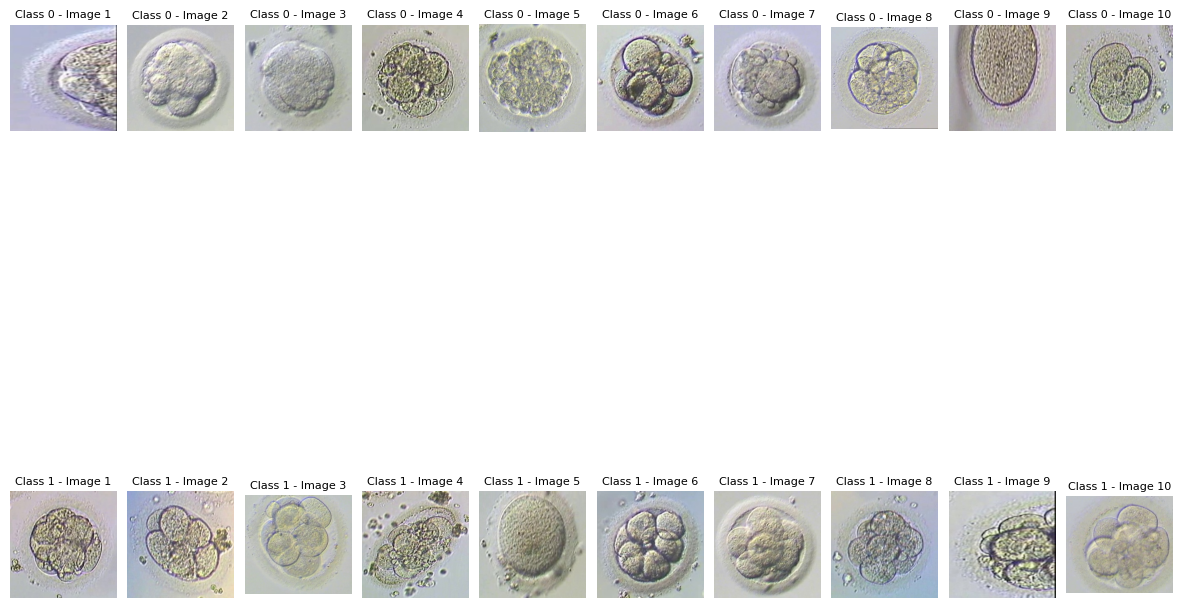

In [ ]:
# Number of sample images to display for each class
num_samples = 10

# Get the paths for the first 10 images of each class
class0_image_paths = []
class1_image_paths = []
for image_name in train_df[train_df['Class'] == 0]['Image'].head(num_samples):
    class0_image_paths.append(os.path.join(train_dir, image_name))
for image_name in train_df[train_df['Class'] == 1]['Image'].head(num_samples):
    class1_image_paths.append(os.path.join(train_dir, image_name))

# Load the images
class0_images = []
class1_images = []
for path in class0_image_paths:
    img = cv2.imread(path)
    class0_images.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
for path in class1_image_paths:
    img = cv2.imread(path)
    class1_images.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# Display the images using subplot with adjusted spacing
plt.figure(figsize=(15, 10))

# Plot images from Class 0
for i, image in enumerate(class0_images, 1):
    plt.subplot(2, num_samples, i)
    plt.imshow(image)
    plt.title(f"Class 0 - Image {i}", fontsize=8, pad=5)  # Küçük font ve başlık boşluğu
    plt.axis('off')

# Plot images from Class 1
for i, image in enumerate(class1_images, 1):
    plt.subplot(2, num_samples, i + num_samples)
    plt.imshow(image)
    plt.title(f"Class 1 - Image {i}", fontsize=8, pad=5)  # Küçük font ve başlık boşluğu
    plt.axis('off')

# Alt ve üst boşlukları artırarak başlıkların çakışmasını önle
plt.subplots_adjust(top=0.9, bottom=0.1, hspace=0.4, wspace=0.1)
plt.show()

### <span style="color:#e76f51;"> Let's Compare D3 and D5 embryo : </span>

This code filters the images according to types "D3" and "D5" and selects and loads 10 images from each class (Class 0 and Class 1) separately. These images are then visualized in a grid layout with 4 rows (D3-Class 0, D3-Class 1, D5-Class 0, D5-Class 1) and num_samples columns.

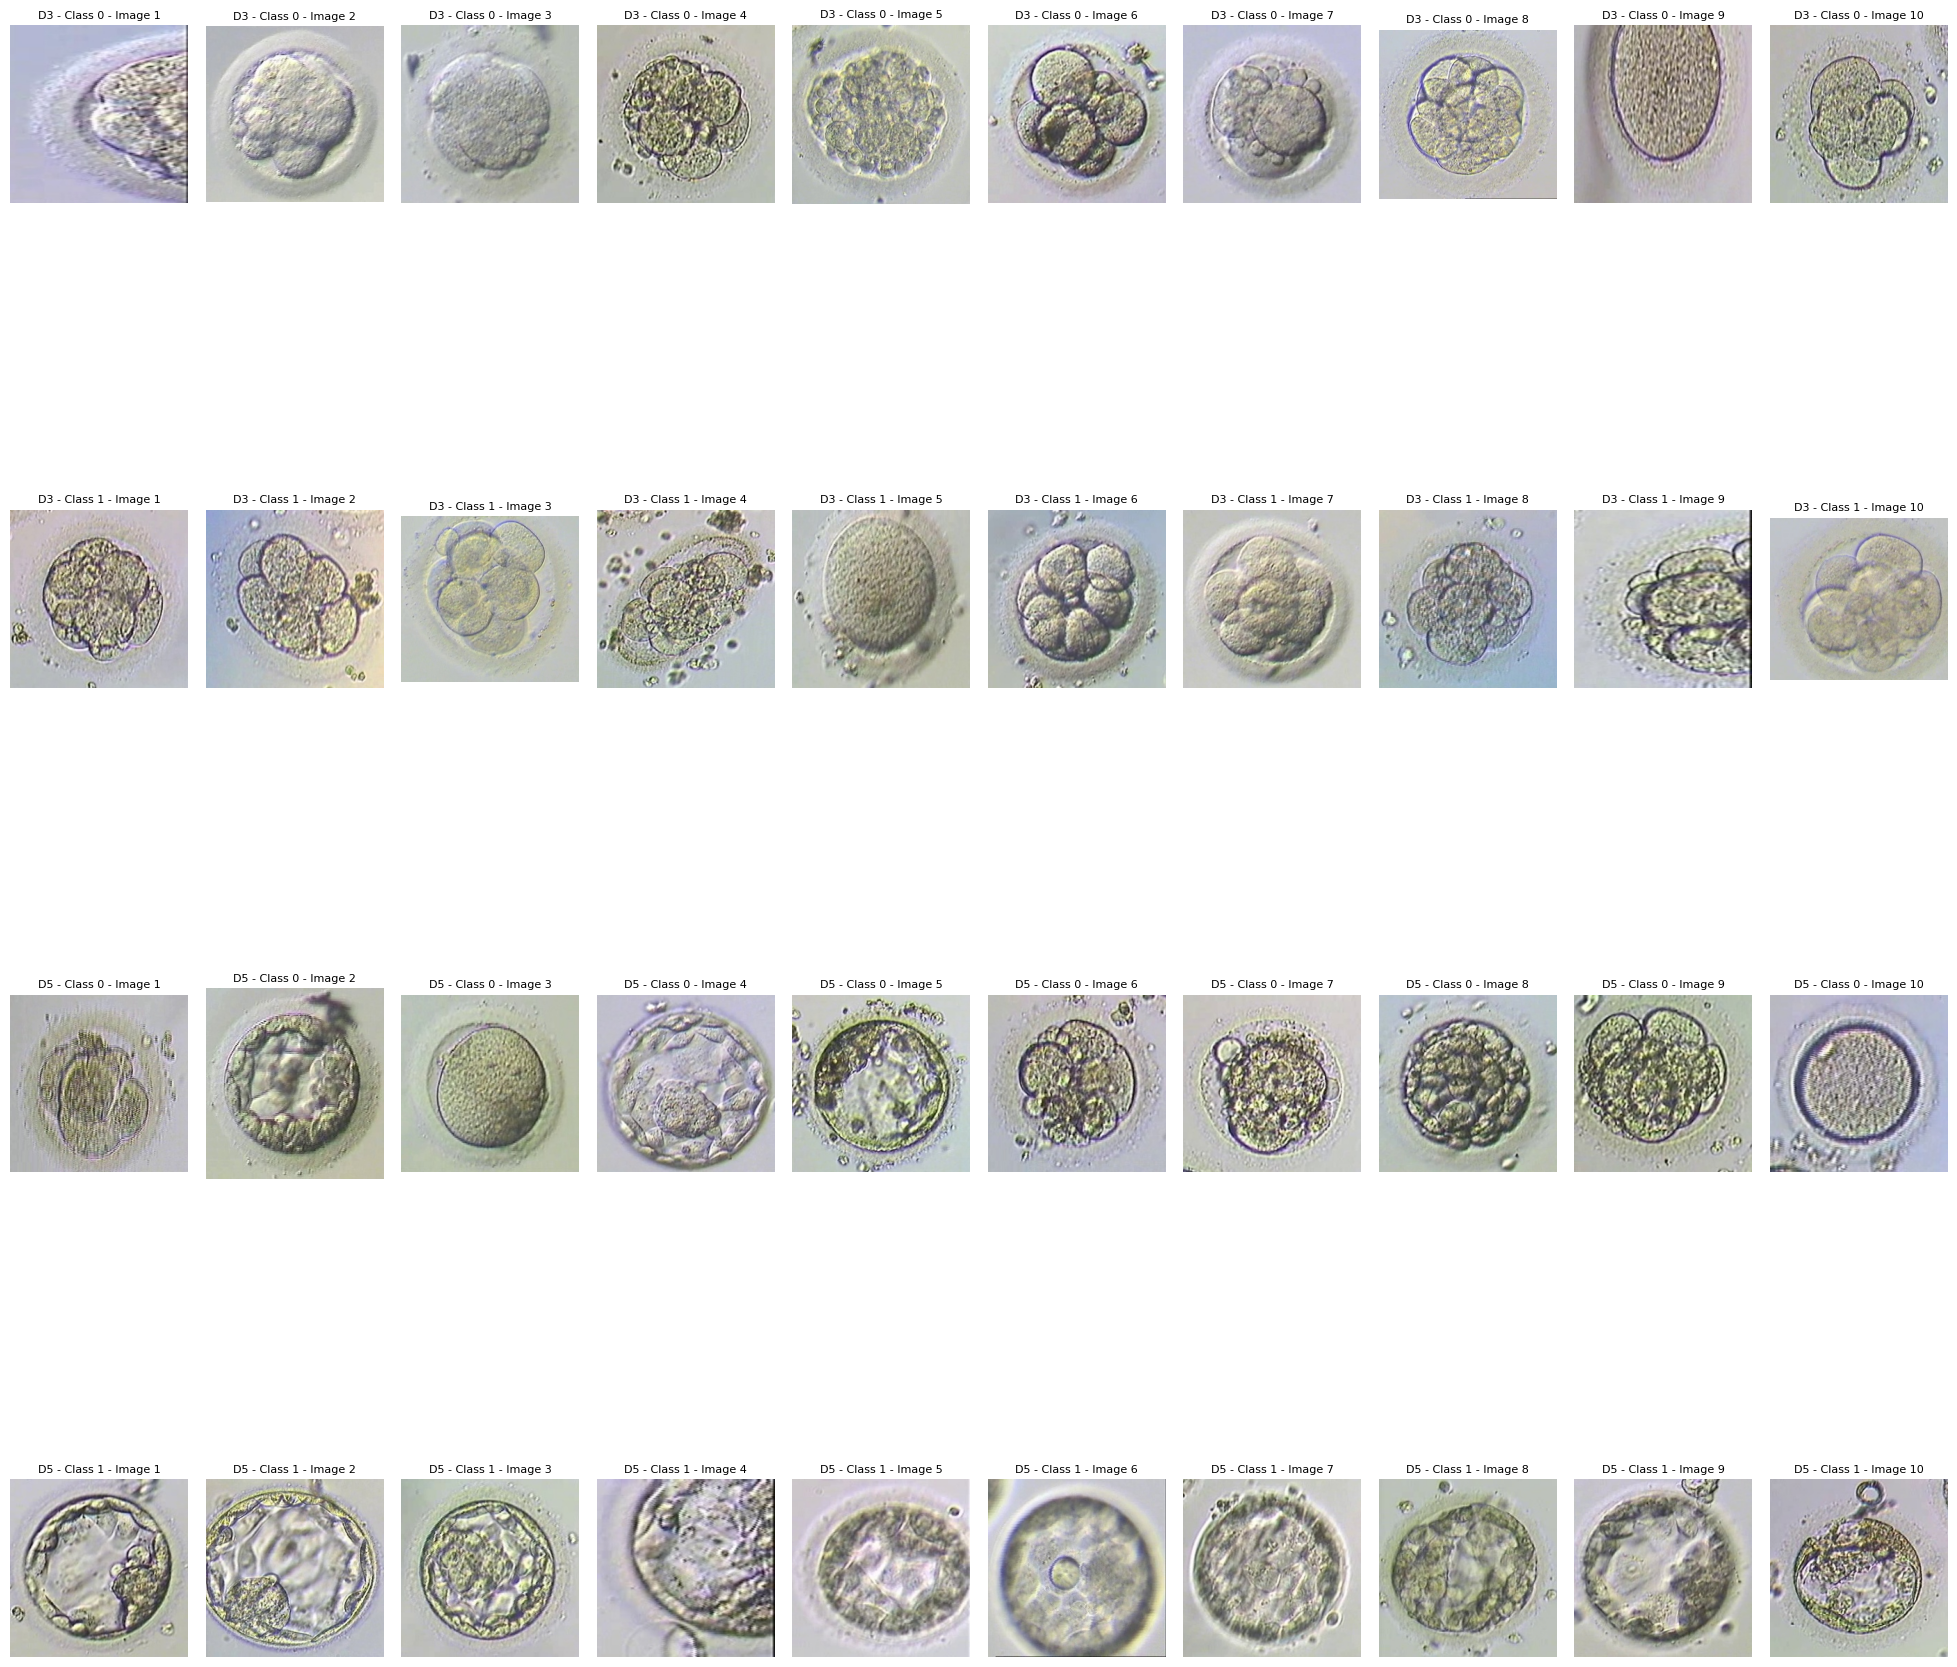

In [ ]:
# Paths for images based on type and class
d3_class0_image_paths = []
d3_class1_image_paths = []
d5_class0_image_paths = []
d5_class1_image_paths = []

# Filter and collect image paths for each category
for image_name in train_df[train_df['Image'].str.startswith('D3') & (train_df['Class'] == 0)]['Image'].head(num_samples):
    d3_class0_image_paths.append(os.path.join(train_dir, image_name))
for image_name in train_df[train_df['Image'].str.startswith('D3') & (train_df['Class'] == 1)]['Image'].head(num_samples):
    d3_class1_image_paths.append(os.path.join(train_dir, image_name))
for image_name in train_df[train_df['Image'].str.startswith('D5') & (train_df['Class'] == 0)]['Image'].head(num_samples):
    d5_class0_image_paths.append(os.path.join(train_dir, image_name))
for image_name in train_df[train_df['Image'].str.startswith('D5') & (train_df['Class'] == 1)]['Image'].head(num_samples):
    d5_class1_image_paths.append(os.path.join(train_dir, image_name))

# Load the images
d3_class0_images = []
d3_class1_images = []
d5_class0_images = []
d5_class1_images = []

for path in d3_class0_image_paths:
    img = cv2.imread(path)
    d3_class0_images.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
for path in d3_class1_image_paths:
    img = cv2.imread(path)
    d3_class1_images.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
for path in d5_class0_image_paths:
    img = cv2.imread(path)
    d5_class0_images.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
for path in d5_class1_image_paths:
    img = cv2.imread(path)
    d5_class1_images.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# Display the images using plt.subplots for better control
fig, axes = plt.subplots(4, num_samples, figsize=(25, 20))

# Plot images from D3 type with Class 0
for i, (image, ax) in enumerate(zip(d3_class0_images, axes[0]), 1):
    ax.imshow(image)
    ax.set_title(f"D3 - Class 0 - Image {i}", fontsize=8, pad=5)
    ax.axis('off')

# Plot images from D3 type with Class 1
for i, (image, ax) in enumerate(zip(d3_class1_images, axes[1]), 1):
    ax.imshow(image)
    ax.set_title(f"D3 - Class 1 - Image {i}", fontsize=8, pad=5)
    ax.axis('off')

# Plot images from D5 type with Class 0
for i, (image, ax) in enumerate(zip(d5_class0_images, axes[2]), 1):
    ax.imshow(image)
    ax.set_title(f"D5 - Class 0 - Image {i}", fontsize=8, pad=5)
    ax.axis('off')

# Plot images from D5 type with Class 1
for i, (image, ax) in enumerate(zip(d5_class1_images, axes[3]), 1):
    ax.imshow(image)
    ax.set_title(f"D5 - Class 1 - Image {i}", fontsize=8, pad=5)
    ax.axis('off')

# Adjust spacing to prevent title overlap
plt.subplots_adjust(top=0.95, bottom=0.05, hspace=0.4, wspace=0.1)
plt.show()

# Preprocessing ⚙️
***

### <span style="color:#e76f51;"> Let's Create a pipeline which will be used for training and Validation : </span>

This code applies data augmentation and ImageNet normalization to prepare the image data for training, then creates data generators by splitting the dataset into training (80%) and validation (20%) sets.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input  # ImageNet normalizasyonu için
from sklearn.utils import shuffle

# Define the image size
IMG_SIZE = (224, 224)

# Initialize data generators with optimized augmentation and ImageNet preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,  # Daha az agresif döndürme
    width_shift_range=0.1,  # Daha küçük kaydırmalar
    height_shift_range=0.1,
    shear_range=0.1,  # Daha az deformasyon
    zoom_range=0.2,  # Daha dengeli yakınlaştırma
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],  # Parlaklık değişiklikleri ekleniyor
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input  # ImageNet normalizasyonu
)

# Split the dataframe into train and validation sets (20% for validation)
from sklearn.model_selection import train_test_split

# Stratified split to ensure class balance
train_df, valid_df = train_test_split(
    train_df,
    test_size=0.2,  # %20 doğrulama seti
    stratify=train_df["Class"],  # Sınıf dengesini koru
    random_state=42
)

# No need to shuffle train_df manually, as train_generator will shuffle

# Create data generators with a larger batch size
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_dir,
    x_col="Image",
    y_col="Class",
    class_mode="raw",
    target_size=IMG_SIZE,
    batch_size=32,  # Daha büyük batch size
    shuffle=True
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    directory=train_dir,
    x_col="Image",
    y_col="Class",
    class_mode="raw",
    target_size=IMG_SIZE,
    batch_size=32,  # Daha büyük batch size
    shuffle=False
)

Found 537 validated image filenames.
Found 135 validated image filenames.


This code checks the distribution of labels in the training and validation sets, then visualizes a set of images from the training set and their labels. The images are displayed in a grid layout and unused spaces are hidden.

Unique labels in train_generator: Counter({np.int64(0): 458, np.int64(1): 79})
Unique labels in valid_generator: Counter({np.int64(0): 115, np.int64(1): 20})


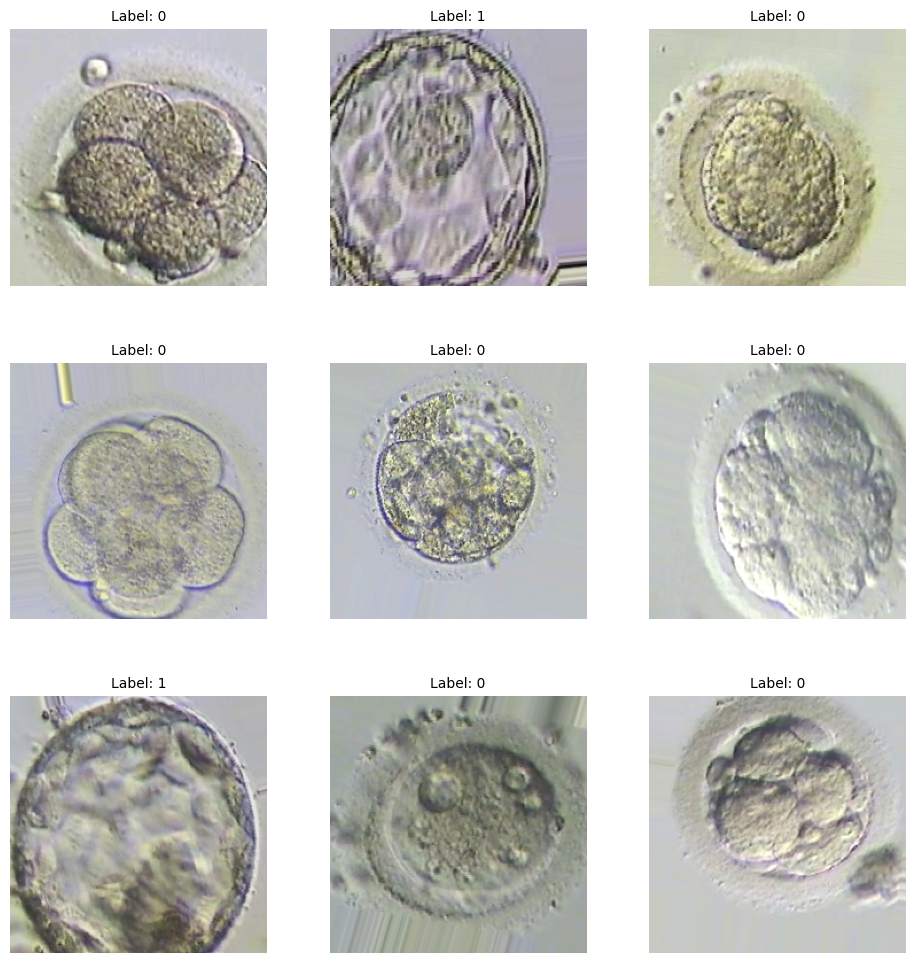

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

# Check labels in train_generator
train_labels = train_generator.labels

# Check labels in valid_generator
valid_labels = valid_generator.labels

# Use Counter to get unique labels and their counts
train_label_counts = Counter(train_labels)
valid_label_counts = Counter(valid_labels)

# Print unique labels and their counts
print("Unique labels in train_generator:", train_label_counts)
print("Unique labels in valid_generator:", valid_label_counts)

# Get a batch of images and labels from train_generator
images, labels = next(train_generator)

# Define how many images to display (dynamic)
num_images_to_display = 9
rows = 3
cols = 3

# Plot images using plt.subplots for better control
fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
axes = axes.flatten()  # 1D array for easier iteration

for i in range(min(num_images_to_display, len(images))):
    axes[i].imshow(images[i])
    axes[i].set_title(f"Label: {labels[i]}", fontsize=10)
    axes[i].axis('off')

# Hide unused subplots if any
for i in range(num_images_to_display, len(axes)):
    axes[i].axis('off')

# Adjust layout to prevent overlap
plt.subplots_adjust(hspace=0.3, wspace=0.1)
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.metrics import Recall
from tensorflow.keras.applications import MobileNetV3Large

In [ ]:
unique_labels = train_df['Class'].unique()
print(unique_labels)

[1 0]


In [ ]:
x_batch, y_batch = next(train_generator)
unique_labels = set(y_batch)
print(unique_labels)


{np.int64(0), np.int64(1)}


This code checks if the labels in both the DataFrame and the one received from the generator are in "one-hot encoded" format and prints the result

In [ ]:
# Using DataFrame
is_one_hot_encoded = False
for label in train_df['Class']:
    if isinstance(label, (list, np.ndarray)):
        is_one_hot_encoded = True
        break
print(f"Labels are one-hot encoded: {is_one_hot_encoded}")

# Using Generator
is_one_hot_encoded = False
for label in y_batch:
    if isinstance(label, (list, np.ndarray)):
        is_one_hot_encoded = True
        break
print(f"Labels are one-hot encoded: {is_one_hot_encoded}")

Labels are one-hot encoded: False
Labels are one-hot encoded: False


This code trains MobileNetV3Large, EfficientNetB0 and DenseNet121 models and compares their performance on the validation set. It includes determining the optimal threshold, metric calculation, visualization and performance table generation.

Training on GPU.

Training MobileNetV3Large...

Epoch 1/5
15/17 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step - accuracy: 0.6264 - loss: 0.7022

17/17 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.6245 - loss: 0.7075 - val_accuracy: 0.3778 - val_loss: 0.7990 - learning_rate: 1.0000e-04
Epoch 2/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.4702 - loss: 0.7305

17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 438ms/step - accuracy: 0.4703 - loss: 0.7308 - val_accuracy: 0.4370 - val_loss: 0.7723 - learning_rate: 1.0000e-04
Epoch 3/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 413ms/step - accuracy: 0.4563 - loss: 0.7695 - val_accuracy: 0.4222 - val_loss: 0.7725 - learning_rate: 1.0000e-04
Epoch 4/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.5225 - loss: 0.7249
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 413ms/step - accuracy: 0.5221 - loss: 0.7240 - val_accuracy: 0.4074 - val_loss: 0.7871 - learning_rate: 1.0000e-04
Epoch 5/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 414ms/step - accuracy: 0.4986 - loss: 0.7936 - val_accuracy: 0.4222 - val_loss: 0.7796 - learning_rate: 5.0000e-05

Training EfficientNetB0...

Epoch 1/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 951ms/step - accuracy: 0.4640 - loss: 0.7099

17/17 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.4671 - loss: 0.7093 - val_accuracy: 0.2074 - val_loss: 0.8449 - learning_rate: 1.0000e-04
Epoch 2/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 413ms/step - accuracy: 0.6109 - loss: 0.6754 - val_accuracy: 0.2074 - val_loss: 0.8235 - learning_rate: 1.0000e-04
Epoch 3/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 409ms/step - accuracy: 0.3578 - loss: 0.7200 - val_accuracy: 0.2000 - val_loss: 0.8537 - learning_rate: 1.0000e-04
Epoch 4/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.5613 - loss: 0.6917
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 408ms/step - accuracy: 0.5610 - loss: 0.6929 - val_accuracy: 0.2074 - val_loss: 0.8316 - learning_rate: 1.0000e-04
Epoch 5/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 410ms/step - accuracy: 0.4633 - loss: 0.6673 - val_accuracy: 0.2074 - val_loss: 0.8274 - learning_rate: 5.0000e-05

Training DenseNet121...

Epoch 1/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 883ms/step - accurac

17/17 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.5334 - loss: 0.7392 - val_accuracy: 0.8444 - val_loss: 0.5554 - learning_rate: 1.0000e-04
Epoch 2/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.5755 - loss: 0.6593

17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 474ms/step - accuracy: 0.5747 - loss: 0.6592 - val_accuracy: 0.8519 - val_loss: 0.5399 - learning_rate: 1.0000e-04
Epoch 3/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 416ms/step - accuracy: 0.7318 - loss: 0.6150 - val_accuracy: 0.8444 - val_loss: 0.4346 - learning_rate: 1.0000e-04
Epoch 4/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 421ms/step - accuracy: 0.6852 - loss: 0.5764 - val_accuracy: 0.8444 - val_loss: 0.4254 - learning_rate: 1.0000e-04
Epoch 5/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 414ms/step - accuracy: 0.6738 - loss: 0.6444 - val_accuracy: 0.8519 - val_loss: 0.5387 - learning_rate: 1.0000e-04


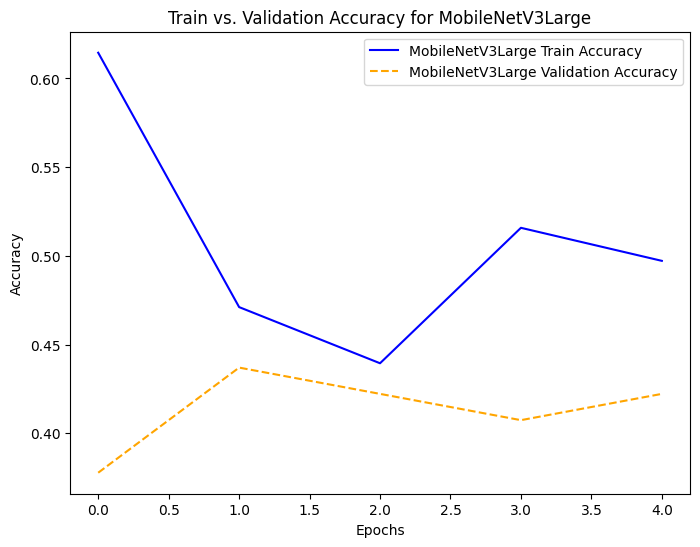

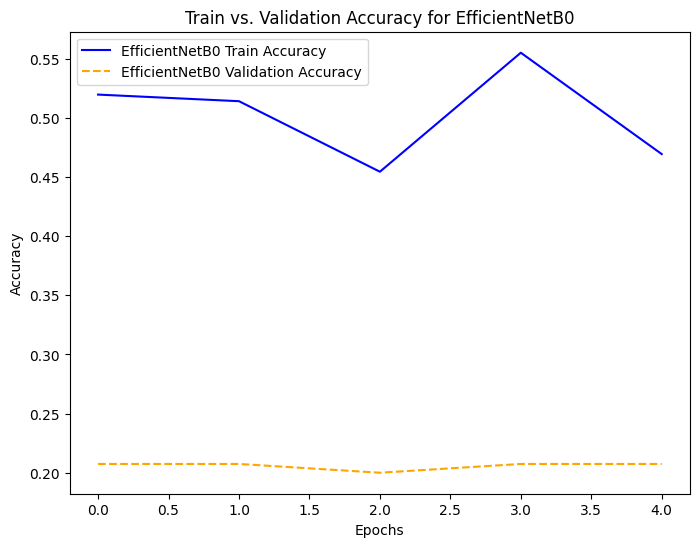

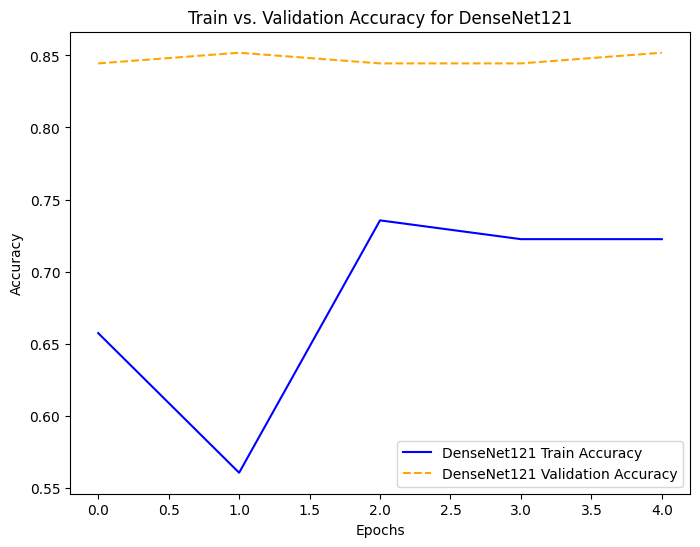

5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step
Optimal threshold for MobileNetV3Large: 0.60 with F1-score: 0.3226
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step
Optimal threshold for EfficientNetB0: 0.60 with F1-score: 0.2759
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step
Optimal threshold for DenseNet121: 0.10 with F1-score: 0.1935


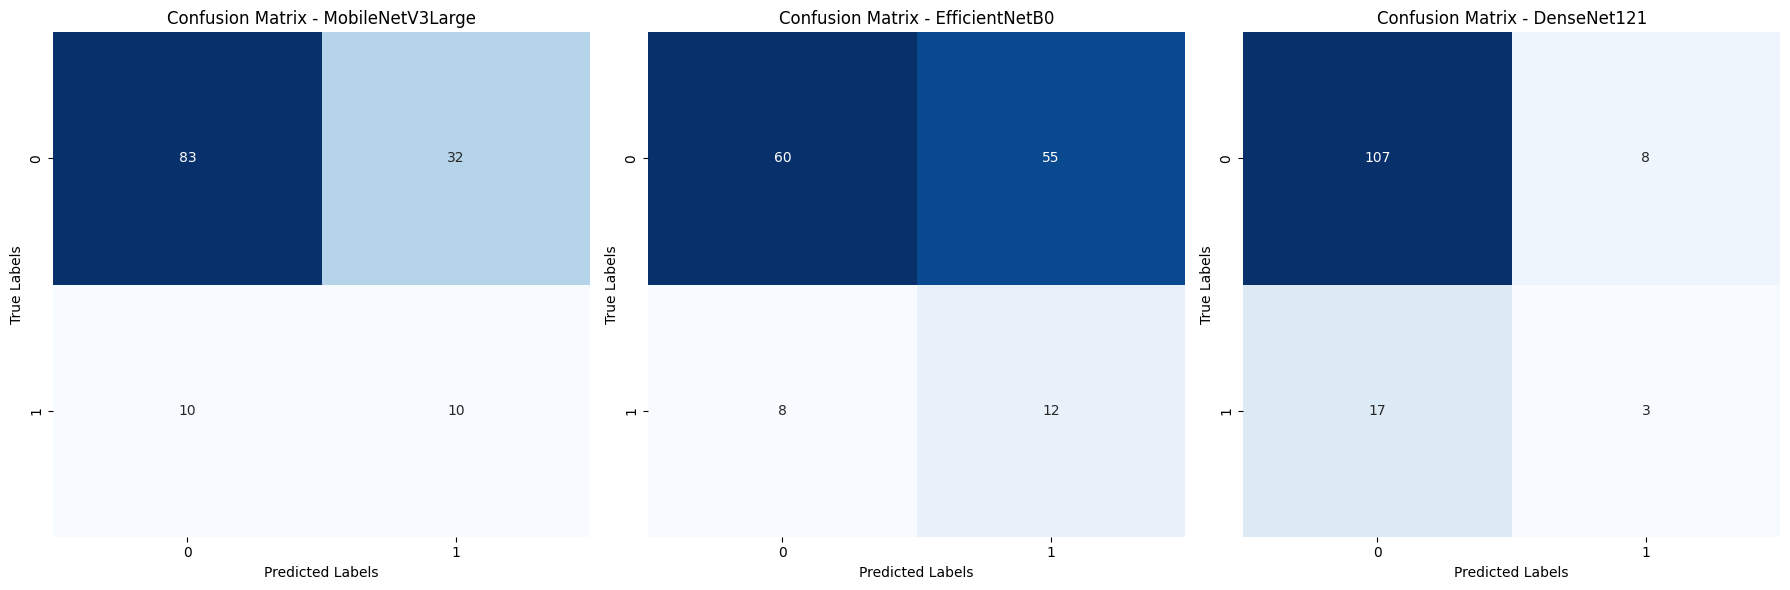


Model Performance Metrics on Validation Set:
           Model  Accuracy  F1-Score  Recall  Precision  Optimal Threshold
MobileNetV3Large    0.6889    0.3226    0.50     0.2381                0.6
  EfficientNetB0    0.5333    0.2759    0.60     0.1791                0.6
     DenseNet121    0.8148    0.1935    0.15     0.2727                0.1


In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Large, EfficientNetB0, DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
import seaborn as sns
import numpy as np

# Define the image size
IMG_SIZE = (224, 224)

# ... [The rest of the data generators code remains unchanged]
# Note: I'm assuming train_df, train_generator, and valid_generator are defined here.

# Check if GPU is available
if tf.config.experimental.list_physical_devices('GPU'):
    print('Training on GPU.')
    device = '/GPU:0'
else:
    print('Training on CPU.')
    device = '/CPU:0'

# Function to build and train a model with explicit arguments
def build_and_train_model(base_model, model_name, train_generator, valid_generator, class_weight_dict):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(units=512, activation='relu')(x)
    x = Dropout(rate=0.5)(x)
    predictions = Dense(units=1, activation='sigmoid')(x)

    # Create the final model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # Define callbacks
    early_stop = EarlyStopping(monitor='val_accuracy', mode='max', patience=11, restore_best_weights=True)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, min_lr=0.00001)
    model_checkpoint = ModelCheckpoint(f'best_model_{model_name}.h5', monitor='val_accuracy', mode='max', save_best_only=True)

    # Train the model
    history = model.fit(
        train_generator,
        epochs=5,
        validation_data=valid_generator,
        callbacks=[early_stop, model_checkpoint, lr_scheduler],
        class_weight=class_weight_dict,
        verbose=1
    )

    return model, history

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=train_df['Class'])
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

# List of models to train
models_to_train = [
    (MobileNetV3Large, "MobileNetV3Large"),
    (EfficientNetB0, "EfficientNetB0"),
    (DenseNet121, "DenseNet121")
]

# Store trained models and histories
trained_models = {}
histories = {}

# Train each model
with tf.device(device):
    for model_class, model_name in models_to_train:
        print(f"\nTraining {model_name}...\n")
        base_model = model_class(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        model, history = build_and_train_model(base_model, model_name, train_generator, valid_generator, class_weight_dict)
        trained_models[model_name] = model
        histories[model_name] = history

# Plot training vs. validation accuracy for each model in separate graphs
for model_name, history in histories.items():
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'], label=f'{model_name} Train Accuracy', color='blue')
    plt.plot(history.history['val_accuracy'], linestyle='--', label=f'{model_name} Validation Accuracy', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title(f'Train vs. Validation Accuracy for {model_name}')
    plt.show()

# Function to find the optimal threshold based on F1-score
def find_optimal_threshold(true_labels, predicted_probs):
    thresholds = np.arange(0.1, 0.9, 0.1)
    f1_scores = []
    for threshold in thresholds:
        preds = (predicted_probs > threshold).astype(int)
        f1 = f1_score(true_labels, preds)
        f1_scores.append(f1)
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    optimal_f1 = f1_scores[optimal_idx]
    return optimal_threshold, optimal_f1

# Confusion Matrix and Metrics for each model
model_names = ["MobileNetV3Large", "EfficientNetB0", "DenseNet121"]

# Lists to store metrics for the table
metrics_data = {
    "Model": [],
    "Accuracy": [],
    "F1-Score": [],
    "Recall": [],
    "Precision": [],
    "Optimal Threshold": []
}

# Create a figure with subplots for each model's confusion matrix
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Iterate over each model
for idx, model_name in enumerate(model_names):
    # Reset the validation generator for each model to ensure consistent order
    valid_generator.reset()

    # Use the trained model directly
    model = trained_models[model_name]

    # Make predictions on the validation set
    valid_predictions = model.predict(valid_generator).flatten()

    # Extract the true labels from the validation generator
    valid_labels_true = valid_generator.labels

    # Find the optimal threshold
    optimal_threshold, optimal_f1 = find_optimal_threshold(valid_labels_true, valid_predictions)
    print(f"Optimal threshold for {model_name}: {optimal_threshold:.2f} with F1-score: {optimal_f1:.4f}")

    # Make class predictions using the optimal threshold
    valid_labels_predicted = (valid_predictions > optimal_threshold).astype(int)

    # Generate the confusion matrix
    cm = confusion_matrix(valid_labels_true, valid_labels_predicted)

    # Visualize the confusion matrix in the corresponding subplot
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False, ax=axes[idx])
    axes[idx].set_xlabel('Predicted Labels')
    axes[idx].set_ylabel('True Labels')
    axes[idx].set_title(f'Confusion Matrix - {model_name}')

    # Calculate metrics
    accuracy = accuracy_score(valid_labels_true, valid_labels_predicted)
    f1 = f1_score(valid_labels_true, valid_labels_predicted)
    recall = recall_score(valid_labels_true, valid_labels_predicted)
    precision = precision_score(valid_labels_true, valid_labels_predicted)

    # Append metrics to the table data
    metrics_data["Model"].append(model_name)
    metrics_data["Accuracy"].append(accuracy)
    metrics_data["F1-Score"].append(f1)
    metrics_data["Recall"].append(recall)
    metrics_data["Precision"].append(precision)
    metrics_data["Optimal Threshold"].append(optimal_threshold)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

# Create a DataFrame for the metrics table
metrics_df = pd.DataFrame(metrics_data)

# Round the metrics to 4 decimal places for better readability
metrics_df[["Accuracy", "F1-Score", "Recall", "Precision", "Optimal Threshold"]] = metrics_df[["Accuracy", "F1-Score", "Recall", "Precision", "Optimal Threshold"]].round(4)

# Display the metrics table
print("\nModel Performance Metrics on Validation Set:")
print(metrics_df.to_string(index=False))

# Reset the generator again for future use
valid_generator.reset()

### <span style="color:#e76f51;">Prediction and Submission</span>

By making predictions on the test dataset, CSV files of the class distribution and prediction results were created for each model. In addition, the class distributions were summarized in a table.

In [ ]:
# Preprocess test images using an ImageDataGenerator
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=test_dir,
    x_col="Image",
    y_col=None,
    class_mode=None,
    target_size=IMG_SIZE,
    batch_size=32,
    shuffle=False
)

# Dictionary to store class distribution for each model's predictions
class_distribution = {
    "Model": [],
    "Class 0 Count": [],
    "Class 1 Count": []
}

# Make predictions for each model and prepare submission files
for model_name in model_names:
    # Use the trained model
    model = trained_models[model_name]

    # Make predictions on the test set
    test_predictions = model.predict(test_generator)

    # Convert predictions to binary labels
    test_labels = [1 if pred > 0.5 else 0 for pred in test_predictions]

    # Prepare the submission dataframe
    submission_df = test_df[['ID']].copy()
    submission_df['Class'] = test_labels

    # Save the submission dataframe to a CSV file
    submission_file_path = f'submission_{model_name}.csv'
    submission_df.to_csv(submission_file_path, index=False)
    print(f"Submission file for {model_name} saved as {submission_file_path}")

    # Calculate class distribution for the predictions
    label_counts = Counter(test_labels)
    class_distribution["Model"].append(model_name)
    class_distribution["Class 0 Count"].append(label_counts.get(0, 0))
    class_distribution["Class 1 Count"].append(label_counts.get(1, 0))

# Create a DataFrame for class distribution
class_distribution_df = pd.DataFrame(class_distribution)

# Display the class distribution table
print("\nClass Distribution of Test Predictions:")
print(class_distribution_df.to_string(index=False))

# Reset the test generator for future use
test_generator.reset()

Found 180 validated image filenames.
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Submission file for MobileNetV3Large saved as submission_MobileNetV3Large.csv
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Submission file for EfficientNetB0 saved as submission_EfficientNetB0.csv
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Submission file for DenseNet121 saved as submission_DenseNet121.csv

Class Distribution of Test Predictions:
           Model  Class 0 Count  Class 1 Count
MobileNetV3Large              0            180
  EfficientNetB0            180              0
     DenseNet121            153             27
